In [385]:
import pandas as pd
import re ,nltk
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

In [386]:
def Visualize(tweet,Name,Class):
    Plot=sns.distplot(Class,kde=False,bins=3,rug=False,color="#07438C")
    Plot.set(xlabel="Negative          Neutral            Positive",
             ylabel="No of tweets",
             title="tweets of {} ".format(Name)
    )
    Plot.plot()
    
    StopWords=set(STOPWORDS)
    all_words = ' '.join([text for text in Xtrain_Obama])
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()

In [387]:
def Clean(Tweets):
    from nltk.tokenize import WordPunctTokenizer
    pattern=re.compile(r'(https|http):?//[a-zA-Z0-9./]+|<.*?>|@\w+|RT @\w+')
    Stopwords={sw for sw in nltk.corpus.stopwords.words('english')}
    processed=[]
    
    for tweet in Tweets:
        # remove html tags,URL links,twitter handles
        tweet=pattern.sub('',tweet)
        
        
        #remove all special characters (except #)
        tweet=re.sub(r'[^a-zA-Z0-9# ]'," ",tweet).lower()
        
        
        # tokenize to remove extra space and remove stopwords
        tweet=tweet.split()
        tweet=' '.join(([w for w in tweet if not w in Stopwords]))
        
        #Convert each word to its root word
        Root=nltk.stem.PorterStemmer()
        Tweet_root=[Root.stem(w) for w in tweet.split()]
        tweet=tweet=str(' '.join(Tweet_root))
        
        processed.append(tweet)
        
        
    return processed

In [388]:
def Parameter_Tuning(parameters,model,X,y):
    gs_clf=GridSearchCV(model,parameters,cv=10,iid=False,n_jobs=-1)
    GS_clf=gs_clf.fit(X,y)
    print("Best Score for the model--->{0}".format(GS_clf.best_score_))
    print("Best Parameters are...")
    print(GS_clf.best_params_)

In [389]:
df_Obama_tweets=df_Obama_tweets=pd.read_excel('trainingObamaRomneytweets.xlsx',sheet_name='Obama')
df_Romney_tweets=pd.read_excel('trainingObamaRomneytweets.xlsx',sheet_name='Romney')

# retains first 4 columns
df_Obama_tweets=df_Obama_tweets[1:].dropna(axis=1,how='all')
df_Romney_tweets=df_Romney_tweets[1:].dropna(axis=1,how='all')



#rename the colums
df_Obama_tweets.columns=['Date','Time','Tweets','Class']
df_Romney_tweets.columns=['Date','Time','Tweets','Class']
df_Obama_tweets.index=range(1,len(df_Obama_tweets)+1)
df_Romney_tweets.index=range(1,len(df_Romney_tweets)+1)


#drop mixed and !!! class for now(we may consider it later)
df_Romney_tweets=df_Romney_tweets[(df_Romney_tweets['Class'].isin((0,1,-1)))]
df_Obama_tweets=df_Obama_tweets[(df_Obama_tweets['Class'].isin((0,1,-1)))]

#drop empty tweet rows
df_Obama_tweets.dropna(subset=['Tweets'],inplace=True)
df_Romney_tweets.dropna(subset=['Tweets'],inplace=True)

#shuffle the dataframe to avoid bias
df_Obama_tweets=shuffle(df_Obama_tweets).reset_index(drop=True)
df_Romney_tweets=shuffle(df_Romney_tweets).reset_index(drop=True)

#raw tweet and class
Obama_tweet=df_Obama_tweets['Tweets'].tolist()
Obama_class=df_Obama_tweets['Class'].tolist()

Romney_tweet=df_Romney_tweets['Tweets'].tolist()
Romney_class=df_Romney_tweets['Class'].tolist()

In [390]:
# preprocess the tweets
Xtrain_Obama=Clean(Obama_tweet)
Xtrain_Romney=Clean(Romney_tweet)

In [391]:
# Multinomail NB...

#Vectorize the tweet and initialize the classifiers
tweet_clf=Pipeline([
    ('count_vect',CountVectorizer(max_df=.7)),
    ('vect_tfidf',TfidfTransformer()),
    ('clf',MultinomialNB()),
])

#tuning the parameters
parameters={
    'count_vect__ngram_range':[(1,1),(1,2)],
    'count_vect__max_df':(.5,.6,.8,.9),
    'vect_tfidf__use_idf':(True,False),
    'clf__alpha':(1e-2,1e-3)
}

Parameter_Tuning(parameters,tweet_clf,Xtrain_Obama,Obama_class)

Best Score for the model--->0.5795146823167918
Best Parameters are...
{'count_vect__max_df': 0.5, 'count_vect__ngram_range': (1, 2), 'clf__alpha': 0.01, 'vect_tfidf__use_idf': False}


In [ ]:
#Linear SVM
tweet_clf=Pipeline([
    ('count_vect',CountVectorizer(max_df=.7)),
    ('vect_tfidf',TfidfTransformer()),
    ('clf',LinearSVC(loss='hinge', penalty='l2', random_state=42,
                          max_iter=5)),
])


#tuning the parameters
parameters={
    'count_vect__ngram_range':[(1,1),(1,2)],
    'count_vect__max_df':(.5,.6,.8,.9),
    'vect_tfidf__use_idf':(True,False),
    'clf__C':(1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3)
}

Parameter_Tuning(parameters,tweet_clf,Xtrain_Obama,Obama_class)

In [ ]:
#Logistic Regression
tweet_clf=Pipeline([
    ('count_vect',CountVectorizer(max_df=.7)),
    ('vect_tfidf',TfidfTransformer()),
    ('clf',LogisticRegression(random_state=0)),
])


#tuning the parameters
parameters={
    'count_vect__ngram_range':[(1,1),(1,2)],
    'count_vect__max_df':(.5,.6,.8,.9),
    'vect_tfidf__use_idf':(True,False),
    'clf__C':(1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3),
    'clf__penalty': ['l2']
}

Parameter_Tuning(parameters,tweet_clf,Xtrain_Obama,Obama_class)

In [382]:
def hashtag(tweets):
    hashtag=[]
    for tweet in tweets:
        ht=re.findall(r'#(\w+)',tweet)
        if ht: hashtag.append(ht)
    return hashtag

def plot(HashTag):
    a = nltk.FreqDist(HashTag)
    d = pd.DataFrame({'Hashtag': list(a.keys()),
                      'Count': list(a.values())})
    # selecting top 10 most frequent hashtags     
    d = d.nlargest(columns="Count", n = 10) 
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
    ax.set(ylabel = 'Count')
    plt.show()
    

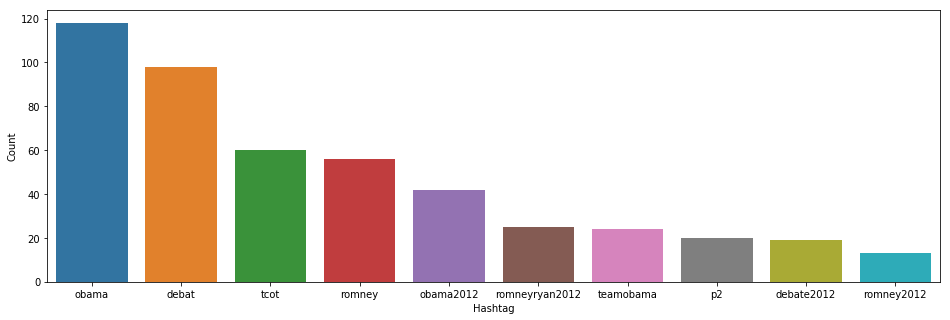

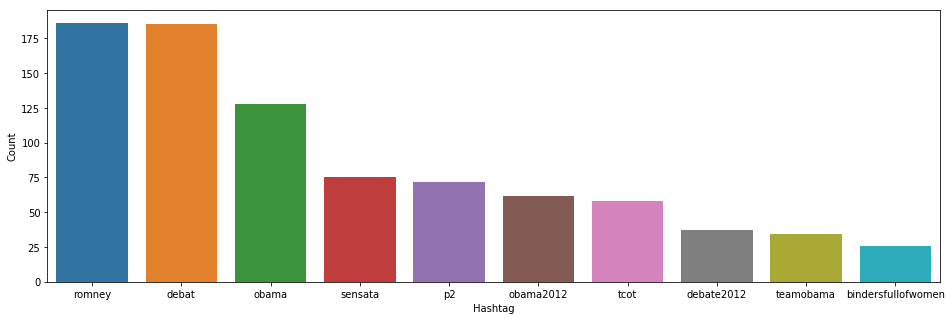

In [384]:
#Analysing Hashtags

#Positive tweets
positive_Romney=df_Romney_tweets.loc[df_Romney_tweets['Class']==1]['Tweets']
positive_Obama=df_Obama_tweets.loc[df_Obama_tweets['Class']==1]['Tweets']
positive_raw=positive_Romney.append(positive_Obama)

positive=Clean(positive_raw)
HT_positive=sum(hashtag(positive),[])

plot(HT_positive)

#Negative tweets
Negative_Romney=df_Romney_tweets.loc[df_Romney_tweets['Class']==-1]['Tweets']
Negative_Obama=df_Obama_tweets.loc[df_Obama_tweets['Class']==1]['Tweets']
Negative_raw=Negative_Romney.append(Negative_Obama)

Negative=Clean(Negative_raw)
HT_Negative=sum(hashtag(Negative),[])

plot(HT_Negative)